### Directly Download from GC and save as netcdf files
- This is for those who cannot use zarr/python for processing the CMIP6 datasets
- Please note that the netcdf files have CF-compliant time grids, but might not be what you are used to

In [1]:
import numpy as np
import pandas as pd
import os
import gcsfs #google cloud file system. 
import xarray as xr
import warnings
from glob import glob # use * !
import scipy.io as sio

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

In [2]:
from utilities import search_df, add_time_info, get_zdict #extra functions

### Initialization

In [3]:
# Where to write local netcdf files:
username = os.environ['JUPYTERHUB_USER']
mach = os.uname()[1]

zarr_local = f'/home/{username}/netcdf/cmip6/historical'
if not os.path.exists(zarr_local):
    print(f'Please create the directory {zarr_local}')
    

In [4]:
# This is the master CMIP6 Google Cloud catalog
df_cloud = pd.read_csv('https://cmip6.storage.googleapis.com/cmip6-zarr-consolidated-stores-noQC.csv', dtype='unicode')
df_cloud.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,status,severity,issue_url
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310,good,none,none
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718,good,none,none
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127,good,none,none
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809,good,none,none
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127,good,none,none


### Choose basic configuration parameters

In [5]:
# Here we search the CMIP6 data for the datasets you need - using the same keywords as at the ESGF sites
#       https://esgf-node.llnl.gov/search/cmip6/

debug = False

# must choose ONE table_id  (only works for *mon or *day)
table_id = 'Amon'

#must choose LIST of experiments, variables
experiments = ['historical']
variables = ['pr']

# can specify 'All' or give a list or string
#sources = ['CESM2']  # omit the [] to get all models with CESM2 in their name
sources = 'All'
#members = ['r1i1p1f1']
members = 'All'

In [6]:
search = {'table_id':table_id}
search['experiment_id'] = experiments
search['variable_id'] = variables
if sources != 'All':
    search['source_id'] = sources
if members != 'All':
    search['member_id'] = members
    
df_available = search_df(df_cloud, **search)

print('number of matching datasets',len(df_available))
df_available.zstore.values

#523 historical simulations < 536 on the cite directly. Do I want to figure out which simulations are missing? 
# Or do I trust that they are missing for a reason?

number of matching datasets 523


array(['gs://cmip6/CMIP/AS-RCEC/TaiESM1/historical/r1i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r1i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r2i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r3i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r4i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r5i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/AWI/AWI-ESM-1-1-LR/historical/r1i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r2i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r3i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/BCC/BCC-ESM1/historical/r1i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/BCC/BCC-ESM1/historical/r2i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/BCC/BCC-ESM1/historical/r3i1p1f1/Amon/pr/gn/',
       'gs://cmip6/CMIP/CAMS/CAMS-

In [7]:
# For proper debugging, it is helpful to add time grid information to dataframe:
if debug:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        dfa = add_time_info(df_available)
else:
    dfa = df_available.copy()

In [8]:
if debug:
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)

    dm = dfa[['experiment_id','source_id','member_id','variable_id','start','stop']].groupby([
             'experiment_id','start','stop','source_id']).nunique()[['member_id']]

    table = pd.DataFrame.pivot_table(dm,
                                     values='member_id',
                                     index=['source_id','start','stop'],
                                     columns=['experiment_id'],
                                     aggfunc=np.sum,
                                     fill_value=0)
    print(table)

In [9]:
dfa.issue_url.unique()

array(['none',
       'https://errata.es-doc.org/static/view.html?uid=ad9e4213-f254-e930-a143-030a4b0f8a32',
       'https://errata.es-doc.org/static/view.html?uid=5ebabff0-388f-07bc-b2cf-d44dcbb2940f',
       'https://errata.es-doc.org/static/view.html?uid=b6302400-3620-c8f1-999b-d192c0349084'],
      dtype=object)

In [10]:
fs = gcsfs.GCSFileSystem(token='anon', access='read_only') #the actual files, not the list of files woohoo FILE SYSTEM
#fs.get_mapper()

In [130]:
def compute_area_and_seasonal_mean(danom, xlim, ylim, slim):
    """
    Weights each grid point by the cos(latitude), computes area mean, normalizing by areaa mean of the weights
    returns:
        DataArray:  global mean for each model
    """  
    xlim = np.array(xlim)
    xlim += (xlim<0 )*360
    if xlim[0]>xlim[1]:
        lon_sel = (danom.lon>xlim[0])+(danom.lon<xlim[1])
    else:
        lon_sel = (danom.lon>xlim[0])*danom.lon<xlim[1]
        
    danom = danom.isel({'lat': (danom.lat>ylim[0])*(danom.lat<ylim[1]), 'lon': lon_sel, 'time': (danom['time'].dt.month >= slim[0])*(danom['time'].dt.month <= slim[1])})
    coslat = np.cos(np.deg2rad(danom.lat))
    d_ones = xr.ones_like(danom)
    weight_mean = (d_ones*coslat).mean(['lat','lon'], keep_attrs=True)
    area_mean = (danom * coslat).mean(['lat','lon'], keep_attrs=True)/weight_mean
    #I use a weighted average. 
    if area_mean.time.dtype!='datetime64[ns]':
        area_mean.indexes['time'].to_datetimeindex()
        #there are lots of dftime.DatetimeNoLeap. this would matter a touch if I used a weighted average.
        
    #month_length = danom.time.dt.days_in_month
    #this actually isn't right! Let's just do an unweighted mean for now :(
    #weights = month_length/sum(month_length[slim[0]:slim[1]+1])
    #Sm = (weights*area_mean)
    #return Sm.groupby(grp).sum(dim='time', keep_attrs=True)
    return area_mean.groupby(area_mean.time.dt.year).mean(dim='time', keep_attrs=True)

In [ ]:
gsurls = dfa.zstore.values #zstore is the url where the data is stored

ds_list = []

for gsurl in gsurls:
    zdict = get_zdict(gsurl) #naomi func for metadata
    institution = zdict['institution_id']
    model = zdict['source_id']
    run = zdict['member_id']
    variable = zdict['variable_id']
    filename = f'{variable}_{institution}_{model}_{run}'
    
    ncfiles = glob(f'{zarr_local}/{filename}.nc') #check not to double-download files
    if len(ncfiles) > 0:
        print(ncfiles, 'already exists')
        continue
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        ds = xr.open_zarr(fs.get_mapper(gsurl),consolidated=True) #gets info about the file. get_mapper! always use consolidated=True

    #month_length = ds.time.dt.days_in_month #for some reason the first one doesn't have this...
        
    for var in [var for var in ds.coords]:
        if 'bounds' in var:
            nvar = var.replace('bounds','bnds')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
        if 'latitude' in var:
            nvar = var.replace('latitude','lat')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
        if 'longitude' in var:
            nvar = var.replace('longitude','lon')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
    
    units = ds.pr.attrs['units']
    Sm = compute_area_and_seasonal_mean(ds, [-20,40], [12,18], [7,9])
    if units=='kg m-2 s-1':
        Sm *= 86400
        ncfile = f'{zarr_local}/{filename}.nc'
        #os.system(f'mkdir -p {ncdir}')
        Sm.to_netcdf(ncfile,mode='w',unlimited_dims='time')  #saves the file. Don't have to do this before I'm ready! But ds is replaced each time...
        ds_list += [Sm]
    else:
        print("skipping model {}".format(model))
    

['/home/rebecca/netcdf/cmip6/historical/pr_AS-RCEC_TaiESM1_r1i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_AWI_AWI-CM-1-1-MR_r1i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_AWI_AWI-CM-1-1-MR_r2i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_AWI_AWI-CM-1-1-MR_r3i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_AWI_AWI-CM-1-1-MR_r4i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_AWI_AWI-CM-1-1-MR_r5i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_AWI_AWI-ESM-1-1-LR_r1i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_BCC_BCC-CSM2-MR_r1i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_BCC_BCC-CSM2-MR_r2i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_BCC_BCC-CSM2-MR_r3i1p1f1.nc'] already exists
['/home/rebecca/netcdf/cmip6/historical/pr_BCC_BCC-ESM1_r1i1p1f1.nc'] already exists
['/home/rebecca/netcdf

/home/naomi/.conda/envs/my3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/home/naomi/.conda/envs/my3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
/home/naomi/.conda/envs/my3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the l

In [106]:
ds.indexes['time'].to_datetimeindex().days_in_month

/home/naomi/.conda/envs/my3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  """Entry point for launching an IPython kernel.


Int64Index([31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
            ...
            31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
           dtype='int64', length=1980)

In [115]:
gsurls = dfa.zstore.values #zstore is the url where the data is stored

gsurl = gsurls[2]
ds2 = xr.open_zarr(fs.get_mapper(gsurl),consolidated=True) #gets info about the file. get_mapper! always use consolidated=True

ds2.time.dt.days_in_month



<xarray.DataArray 'days_in_month' (time: 1980)>
array([31, 28, 31, ..., 31, 30, 31])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00

In [18]:
gsurls = dfa.zstore.values #zstore is the url where the data is stored

ds_list = []

for gsurl in gsurls:
    print(gsurl)
    zdict = get_zdict(gsurl) #naomi func for metadata
    ncdir = zarr_local + gsurl[10:]
    
    model = zdict['source_id']
    variable = zdict['variable_id']
    
    ncfiles = glob(f'{ncdir}{variable}*.nc') #check not to double-download files
    if len(ncfiles) > 0:
        print(ncfiles, 'already exists')
        continue
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        ds = xr.open_zarr(fs.get_mapper(gsurl),consolidated=True) #gets info about the file. get_mapper! always use consolidated=True
        #ds['sfcWind'] = ...
    
    for var in [var for var in ds.coords]:
        if 'bounds' in var:
            nvar = var.replace('bounds','bnds')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
        if 'latitude' in var:
            nvar = var.replace('latitude','lat')
            #print(var,nvar)
            ds = ds.rename({var:nvar})
        if 'longitude' in var:
            nvar = var.replace('longitude','lon')
            #print(var,nvar)
            ds = ds.rename({var:nvar})

    ds_list += [ds]
    
    #ncfile = f'{ncdir}{variable}.nc'
    #os.system(f'mkdir -p {ncdir}')
    #ds.to_netcdf(ncfile,mode='w',unlimited_dims='time')  #saves the file. Don't have to do this before I'm ready! But ds is replaced each time...


gs://cmip6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/
['/home/rebecca/CMIP6-downloads/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/tas.nc'] already exists
gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/
gs://cmip6/ScenarioMIP/NCAR/CESM2/ssp370/r1i1p1f1/Amon/tas/gn/
gs://cmip6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/sfcWind/gn/
gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/sfcWind/gn/
gs://cmip6/ScenarioMIP/NCAR/CESM2/ssp370/r1i1p1f1/Amon/sfcWind/gn/


In [21]:
xr.concat(ds_list, dim='dataset') #this isn't working bc different variables. Exist other ways to combine.

ValueError: variables {'sfcWind'} are present in some datasets but not others. 

In [ ]:
#regridding: xesmf (earth system modelling federation). works for lat-lon, but not time.

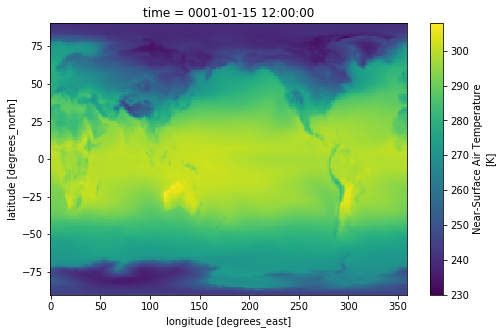

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

ds.tas[0].plot()

In [28]:
! tree -L 9 ~/CMIP6-downloads #unix tree of created files; I didn't create any.

/home/naomi/CMIP6-downloads
├── CMIP
│   └── NCAR
│       └── CESM2
│           ├── historical
│           │   └── r1i1p1f1
│           │       └── Amon
│           │           ├── sfcWind
│           │           │   └── gn
│           │           │       └── sfcWind.nc
│           │           └── tas
│           │               └── gn
│           │                   └── tas.nc
│           └── piControl
│               └── r1i1p1f1
│                   └── Amon
│                       ├── sfcWind
│                       │   └── gn
│                       │       └── sfcWind.nc
│                       └── tas
│                           └── gn
│                               └── tas.nc
└── ScenarioMIP
    └── NCAR
        └── CESM2
            └── ssp370
                └── r1i1p1f1
                    └── Amon
                        ├── sfcWind
                        │   └── gn
                        │       └── sfcWind.nc
                        └── tas
                            └

In [29]:
! du -sh ~/CMIP6-downloads/*/*/*/*

837M	/home/naomi/CMIP6-downloads/CMIP/NCAR/CESM2/historical
6.0G	/home/naomi/CMIP6-downloads/CMIP/NCAR/CESM2/piControl
436M	/home/naomi/CMIP6-downloads/ScenarioMIP/NCAR/CESM2/ssp370


In [59]:
ds = xr.open_dataset('/home/naomi/CMIP6-downloads/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/sfcWind/gn/sfcWind.nc')

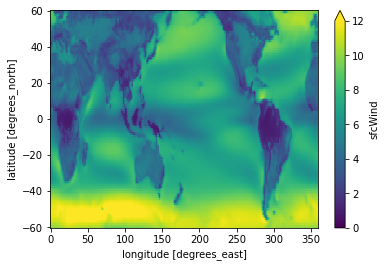

In [60]:
ds.sfcWind.plot(vmin=0,vmax=12)

In [64]:
#Convert longitude coordinates from 0-359 to -180-179:

ds2 = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')

#or

ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby(ds.lon)

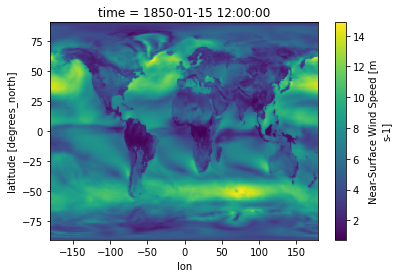

In [65]:
ds2.sfcWind[0].plot()